# Examine trans effect of TP53 Hotspot mutation in Endometrial Cancer

### Specifically examine Protein Abundance of TP53, AURKA, CDK1, XPO1, and STK11

#### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import cptac
import cptac.utils as ut

import seaborn as sns
import matplotlib.pyplot as plt

#Use Ovarian cancer object
co = cptac.Endometrial()

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Use parse hotspot utility to analyze TP53 hotspot mutation in Ovarian cancer

#### Get somatic mutation data from cptac

In [3]:
somatic_mutations = co.get_somatic_mutation()

#### Use parse hotspot utility

In [4]:
vis, binary, detailed, dictionary = ut.parse_hotspot('../../HotspotClusterFiles/UCEC.Somatic.WXS.v072518.b38.maf.3D_Proximity.pairwise.recurrence.l0.r10.clusters', somatic_mutations)


In [5]:
vis

,hotspot_id,patients_within
0,ABCG8,2.0
1,ADPRH,2.0
2,AGFG1,3.0
3,AGO2,2.0
4,ANAPC5,2.0
5,ANK1,2.0
6,ANK1_1,3.0
7,AOX1,3.0
8,APAF1,4.0
9,AR,4.0


As we can see, TP53 has 2 hotspots in Endometrial cancer

#### Select only TP53 Hotspots

In [6]:
#There are 5 TP53 hotspots
TP53_Hotspots = detailed[['TP53','TP53_1']]
TP53_Hotspots.head()

,TP53,TP53_1
sample_id,,
S001,Yes,No
S002,No,No
S003,No,No
S005,No,No
S006,No,Yes_HS


#### Make binary column for samples that have a TP53 Hotspot Mutation

In [7]:
TP53_Hotspots['Hotspot_Mutation'] = ''
for ind, row in TP53_Hotspots.iterrows():
    for col in TP53_Hotspots.columns:
        if row[col] == 'Yes_HS':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

#### Grab only the binary yes/no hotspot mutation

In [8]:
binary_hotspots = TP53_Hotspots['Hotspot_Mutation']

#### Get Proteomic data, append Binary hotspot mutation column

In [10]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['TP53','AURKA','CDK1','XPO1','STK11'], omics_df_name='proteomics', mutations_genes='TP53')

#Remove multiindex from df
#proteomics_df = co.reduce_multiindex(proteomics_df, levels_to_drop='Database_ID')

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['TP53_Location','Sample_Status'],axis=1)
proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
proteomics_df.head()

Name,TP53_proteomics,AURKA_proteomics,CDK1_proteomics,XPO1_proteomics,STK11_proteomics,TP53_Mutation,TP53_Mutation_Status,TP53_Hotspot_Mutation
Sample_ID,,,,,,,,
S001,0.295,NaN,1.100,0.107000,-0.140,[Missense_Mutation],Single_mutation,
S002,0.277,0.311,1.140,-0.037500,0.172,[Wildtype_Tumor],Wildtype_Tumor,
S003,-0.871,NaN,0.220,-0.000832,-0.197,[Wildtype_Tumor],Wildtype_Tumor,
S005,-0.343,-0.798,0.505,0.056100,-0.074,[Wildtype_Tumor],Wildtype_Tumor,
S006,3.010,3.110,1.680,0.501000,-0.609,[Missense_Mutation],Single_mutation,TP53_Hotspot_Mutation


####   Check types

In [11]:
types = []
for ind, row in proteomics_df.iterrows():
    for val in row['TP53_Mutation']:
        if val not in types:
            types.append(val)
            
print(types)

['Missense_Mutation', 'Wildtype_Tumor', 'Nonsense_Mutation', 'In_Frame_Del', 'Frame_Shift_Ins', 'Frame_Shift_Del', 'Splice_Site']


#### Classify every sample according to TP53 Mutation Status. Use: Wildtype, Hotspot_Missense, Other_Missense, Truncation

In [2]:
for ind, row in proteomics_df.iterrows():
    #Classify Hotspot Missense Mutations
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    #Classify Truncation Mutations
    if 'Frame_Shift_Ins' in row['TP53_Mutation'] or 'Frame_Shift_Del' in row['TP53_Mutation'] or 'Nonsense_Mutation' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
    #Classify Wildtype
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
        
    #Classify Other Missense Mutations
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'Missense_Mutation' in row['TP53_Mutation'] or 'In_Frame_Del' in row['TP53_Mutation'] or 'In_Frame_Ins' in row['TP53_Mutation'] or 'Splice_Site' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'

#Drop columns we no longer need, display df
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status', 'TP53_Hotspot_Mutation'], axis = 1)
proteomics_df

NameError: name 'proteomics_df' is not defined

### Perform t-tests on each protein, comparing Hotspot-Wildtype, Hotspot-Truncation, and Hotspot-Other Missense Mutations

In [13]:
for col in proteomics_df:
    if col != 'TP53_Categorical':
        hotspot_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Hotspot_Missense'][col].dropna()
        truncation_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Truncation'][col].dropna()
        other_missense_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Other_Missense'][col].dropna()
        wt_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Wildtype'][col]
        
        #Hotspot-WT comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, wt_df)
        print("Omics: ", col, "\nComparison: Hotspot vs. Wildtype \nP-Value: ", str(pval))
        
        #Hotspot-Truncation comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, truncation_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Truncation \nP-Value: ", str(pval))
        
        #Hotspot-Other Missense comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, other_missense_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Other Missense \nP-Value: ", str(pval))
        print("\n\n")
        

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.003948166058965271

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.018331510285199634



Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.2195004657054032

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.3823928422799321



Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  0.013888806110684989

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.37831324594555926

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.2205381597754096



Omics:  XPO1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  0.0021028445254359426

Omics:  XPO1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.7391418957095827

Omics:

#### Reformat dataframe for plot

In [14]:
plotdf = pd.melt(proteomics_df, id_vars='TP53_Categorical', var_name='Protein', value_name='Abundance')
plotdf = plotdf.replace({'AURKA_proteomics':'AURKA','XPO1_proteomics':'XPO1','TP53_proteomics':'TP53','CDK1_proteomics':'CDK1','STK11_proteomics':'STK11'})
plotdf = plotdf.replace({'Hotspot_Missense':'Hotspot Missense','Other_Missense':'Other Missense'})

### Make plot illustrating proteomic abundance

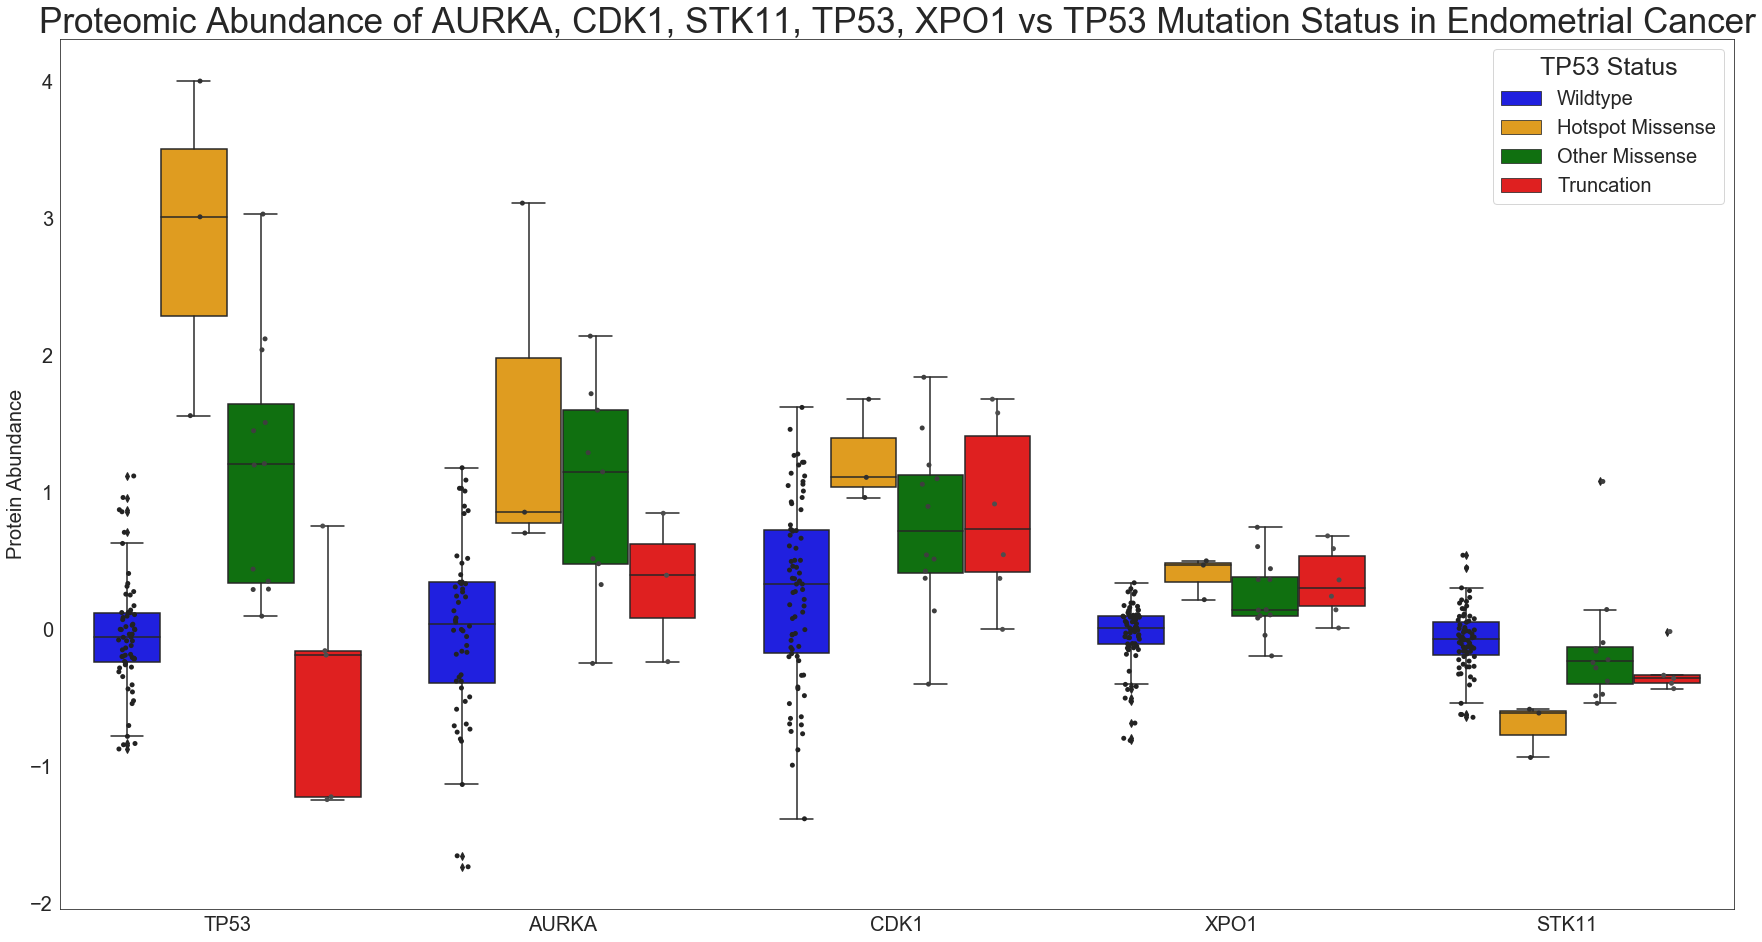

In [16]:
#Set dimensions and Colors
a4_dims = (30, 16)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Wildtype": "blue", "Hotspot Missense": "orange", "Other Missense":"green","Truncation":"red"}

#Make Boxplot
plot = sns.boxplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', palette=my_pal, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'], order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Overlay Striplot
plot = sns.stripplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', color='.3', jitter=True, dodge=True, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'],order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Protein Abundance', fontsize='20')
plot.set_title('Proteomic Abundance of AURKA, CDK1, STK11, TP53, XPO1 vs TP53 Mutation Status in Endometrial Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],['Wildtype','Hotspot Missense','Other Missense','Truncation'], title='TP53 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')


### Conclusions:

#### Show mutations dictionary

In [17]:
dictionary

{'ABCG8': ['p.G439V', 'p.P415H'],
 'ADPRH': ['p.G159C', 'p.R160W'],
 'AGFG1': ['p.S67Y', 'p.T72A'],
 'AGO2': ['p.I453T', 'p.P489S'],
 'ANAPC5': ['p.A303T', 'p.Y417F'],
 'ANK1': ['p.A527T', 'p.V496G'],
 'ANK1_1': ['p.A461V', 'p.R459Q'],
 'AOX1': ['p.A867T', 'p.L739I'],
 'APAF1': ['p.G328C', 'p.L297I'],
 'AR': ['p.A688V', 'p.H690Y'],
 'AR_1': ['p.F827L', 'p.N824H'],
 'ARHGEF7': ['p.R145W', 'p.R150H'],
 'ATP7B': ['p.C108Y', 'p.S105L'],
 'BAI3': ['p.C537F', 'p.M522T'],
 'BRD1': ['p.A966V', 'p.P965L'],
 'BTK': ['p.I580S', 'p.T643P'],
 'C4A': ['p.L855I', 'p.S893T'],
 'CASK': ['p.K495N', 'p.L556P'],
 'CASQ2': ['p.D325N', 'p.E319D'],
 'CCNE1': ['p.H306D', 'p.P333A'],
 'CDC37': ['p.I195T', 'p.R270H'],
 'CDK16': ['p.A377T', 'p.L366P'],
 'COPS4': ['p.E219K', 'p.H218N'],
 'CRYBA4': ['p.A148V', 'p.D167N'],
 'CRYBB1': ['p.E65K', 'p.R72C'],
 'CTNNB1': ['p.D32G',
  'p.D32H',
  'p.D32N',
  'p.D32V',
  'p.D32Y',
  'p.D32_S33delinsA',
  'p.G34E',
  'p.G34R',
  'p.G34V',
  'p.S33P'],
 'CUL5': ['p.F450V', 